In [1]:
!pip install catboost

     |████████████████████████████████| 66.3MB 44kB/s 


In [2]:
#import tensorflow as tf

#device_name = tf.test.gpu_device_name()

#if device_name == '/device:GPU:0':
#    print('Found GPU at: {}'.format(device_name))
#else:
#    raise SystemError('GPU device not found')

# Исследовательский анализ данных

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(style="ticks")

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.dummy import DummyClassifier

from catboost import CatBoostClassifier, Pool
from datetime import date


Загурзим все наши данные и посмотрим что они из себя предстоваляют, в нашем распоряжении 4 файла:
- contract.csv - данные о контрактах
- personal.csv - персональная информации о клиентах
- internet.csv - данные о подключенном интернете
- phone.csv - данные о подключенном телефоне

In [4]:
#contracts = pd.read_csv('./contract.csv')
#personals = pd.read_csv('./personal.csv')
#internet = pd.read_csv('./internet.csv')
#phone = pd.read_csv('./phone.csv')

In [5]:
contracts = pd.read_csv('/datasets/final_provider/contract.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
personals = pd.read_csv('/datasets/final_provider/personal.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [6]:
def df_info(df):
    df.info()
    display(df.describe())
    display(df.sample(10))
    print("Количество полных дубликатов в датафрэйме: {}".format(contracts.duplicated().sum()))

## Анализ данных о контрактах

Изучим наш набор данных 

In [7]:
df_info(contracts)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
6342,3384-CTMSF,2016-03-01,No,Month-to-month,Yes,Electronic check,104.10,5135.15
2059,7483-IQWIB,2017-01-01,No,Month-to-month,Yes,Electronic check,92.95,3415.25
3289,9626-VFRGG,2016-09-01,No,Month-to-month,Yes,Bank transfer (automatic),88.50,3645.05
1232,1689-MRZQR,2017-02-01,2019-12-01 00:00:00,Month-to-month,No,Electronic check,78.30,2564.3
802,8859-AXJZP,2016-11-01,No,Two year,Yes,Mailed check,23.80,903.8
3244,7966-YOTQW,2019-04-01,No,Month-to-month,Yes,Credit card (automatic),54.50,568.2
6551,6728-VOIFY,2014-11-01,No,One year,Yes,Electronic check,96.00,6109.75
1974,1024-VRZHF,2019-02-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,74.95,825.7
4801,0988-AADSA,2014-02-01,No,Two year,No,Bank transfer (automatic),80.85,5824.75
3365,3865-ZFZIB,2018-07-01,No,Two year,No,Mailed check,19.65,358.15


Количество полных дубликатов в датафрэйме: 0


В датафрэйме с информацией о контрактах у нас 7043 записи, без пропусков и без полных дубликатов, многие категориальные поля представлены в виде не правильного типа, например BeginDate(дата), EndDate(дата), TotalCharges(число), а так же категориальные переменные Type, PaperlessBilling и PaymentMethod представлены как строки, PaperlessBilling должно быть булевым типом.

Приведем наши колонки к нужному типу, чтобы лучше изучить данные, начнём с преобразования в даты столбцы BeginDate и EndDate

In [8]:
contracts['BeginDate'] = pd.to_datetime(contracts['BeginDate'], format='%Y-%m-%d')
contracts['BeginDate_year'] = pd.DatetimeIndex(contracts['BeginDate']).year
contracts['BeginDate_month'] = pd.DatetimeIndex(contracts['BeginDate']).month
contracts['EndDate'] = pd.to_datetime(contracts['EndDate'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
contracts['EndDate_year'] = pd.DatetimeIndex(contracts['EndDate']).year
contracts['EndDate_month'] = pd.DatetimeIndex(contracts['EndDate']).month
contracts.info()
contracts.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   BeginDate_year    7043 non-null   int64         
 9   BeginDate_month   7043 non-null   int64         
 10  EndDate_year      1869 non-null   float64       
 11  EndDate_month     1869 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(2), object(5)
memory usage: 660.4+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,BeginDate_year,BeginDate_month,EndDate_year,EndDate_month
4854,1337-BOZWO,2018-08-01,NaT,One year,No,Credit card (automatic),46.40,812.4,2018,8,NaN,NaN
1662,2058-DCJBE,2019-06-01,2019-11-01,Month-to-month,Yes,Electronic check,69.75,324.6,2019,6,2019.0,11.0
1535,7905-NJMXS,2019-07-01,NaT,Month-to-month,No,Electronic check,64.20,475,2019,7,NaN,NaN
5204,4282-ACRXS,2016-12-01,NaT,Month-to-month,Yes,Electronic check,24.85,955.75,2016,12,NaN,NaN
1774,5207-PLSTK,2020-01-01,NaT,Month-to-month,Yes,Mailed check,48.75,48.75,2020,1,NaN,NaN


После привидения к типу datetime мы можем увидеть что у нас появились пропуски в EndDate, что можно трактовать как действующий контракт, таким образом в нашем датафрэйме 1869 завершенных контрактов и 5174 действующих, это и является нашем целевым признаком. Но так же возможно что пользователь закрыл один контракт и открыл другой, проверим данные на дубликаты по customerId.

In [9]:
print("Количество пользователей закрывших контракт и открывших новый: {}".format(contracts['customerID'].duplicated().sum()))

Количество пользователей закрывших контракт и открывших новый: 0


Пользователей повторно открывших контракты нет.

Преобразуем поле PaperlessBilling в булевый тип, предварительно проверив позволяют ли это сделать его значения.

In [10]:
contracts['PaperlessBilling'].value_counts()

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

Да, в нашем поле всего лишь два значения, можем смело преобразовывать их в 0 и 1, где 0 - No и 1 - Yes. Напишем фунцкцию для преобразования таких данных.

In [11]:
def cast_yes_no_to_one_zero(df, columns):
    mapper = {'Yes': 1, 'No': 0}
    for column in columns:
        try:
            df[column] = df[column].replace(mapper)
        except:
            print("Не удалось конвертировать колонку {}".format(column))
    df.info()
    return df

In [12]:
contracts = cast_yes_no_to_one_zero(contracts, ['PaperlessBilling'])
contracts.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   BeginDate_year    7043 non-null   int64         
 9   BeginDate_month   7043 non-null   int64         
 10  EndDate_year      1869 non-null   float64       
 11  EndDate_month     1869 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(3), object(4)
memory usage: 660.4+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,BeginDate_year,BeginDate_month,EndDate_year,EndDate_month
145,5716-EZXZN,2014-09-01,NaT,Two year,1,Credit card (automatic),99.05,6416.7,2014,9,NaN,NaN
221,4443-EMBNA,2014-03-01,NaT,Two year,0,Bank transfer (automatic),24.75,1836.9,2014,3,NaN,NaN
283,9577-WJVCQ,2014-06-01,NaT,Month-to-month,0,Mailed check,54.45,3687.75,2014,6,NaN,NaN
4080,6199-IPCAO,2017-09-01,NaT,Two year,0,Mailed check,26.10,692.55,2017,9,NaN,NaN
7034,0639-TSIQW,2014-03-01,2019-10-01,Month-to-month,1,Credit card (automatic),102.95,6886.25,2014,3,2019.0,10.0


Преобразуем TotalCharges в число

In [13]:
contracts['TotalCharges'] = pd.to_numeric(contracts['TotalCharges'], errors='coerce')
contracts.info()
contracts.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   BeginDate_year    7043 non-null   int64         
 9   BeginDate_month   7043 non-null   int64         
 10  EndDate_year      1869 non-null   float64       
 11  EndDate_month     1869 non-null   float64       
dtypes: datetime64[ns](2), float64(4), int64(3), object(3)
memory usage: 660.4+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,BeginDate_year,BeginDate_month,EndDate_year,EndDate_month
626,5016-IBERQ,2018-03-01,NaT,Month-to-month,0,Electronic check,84.25,1968.10,2018,3,NaN,NaN
3549,6897-RWMUB,2015-01-01,NaT,Two year,1,Bank transfer (automatic),68.05,4158.25,2015,1,NaN,NaN
1851,2485-ITVKB,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,35.10,68.75,2019,9,2019.0,11.0
2063,7833-PKIHD,2015-11-01,NaT,One year,1,Bank transfer (automatic),76.40,3966.30,2015,11,NaN,NaN
6606,6518-LGAOV,2016-09-01,2019-11-01,Month-to-month,1,Electronic check,105.00,4026.40,2016,9,2019.0,11.0


С преобразованием данных мы закончили, теперь можно посмотреть на значения наших категориальных полей.

In [14]:
contracts['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

In [15]:
contracts['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

В дальнейшем перед подготовкой данных к обучению воспользовавшись Ordinal Encoding или One-Hot Encoding мы приведем данные к нужному формату.

С помощью матрицы рассеивания бегло посмотрим на наши данные в целом и выберем на что посмотреть подробнее.

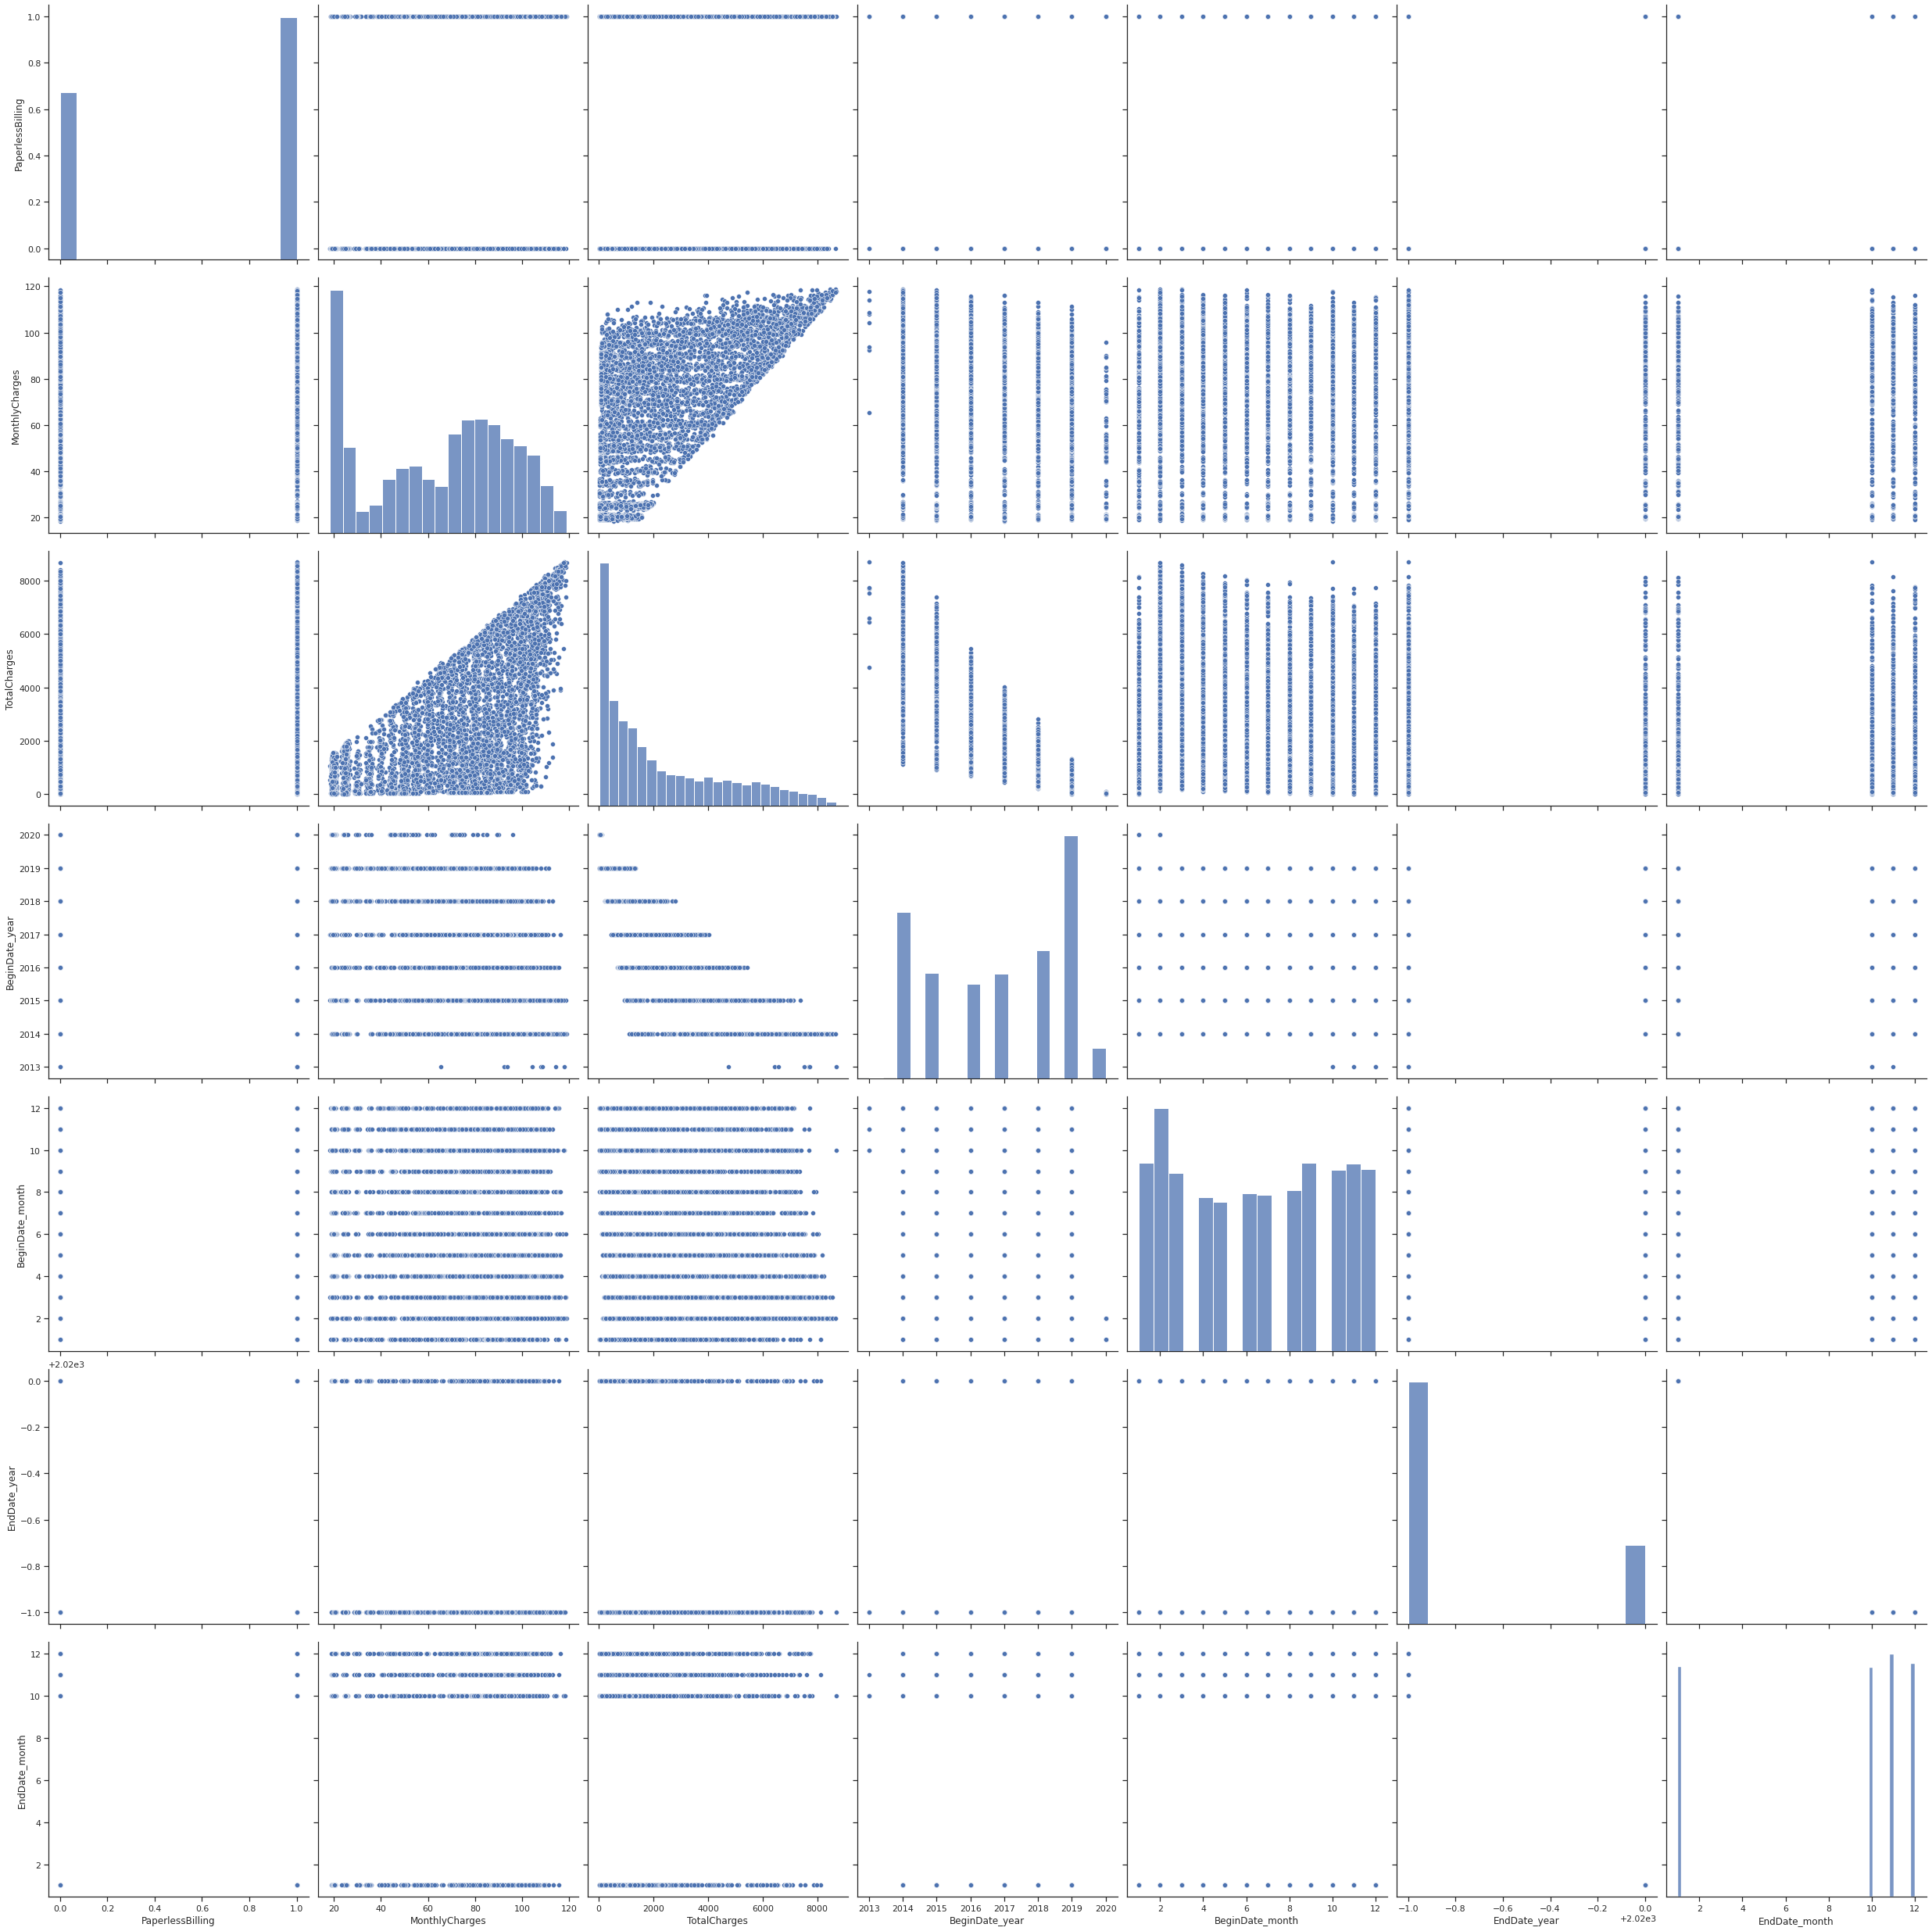

In [16]:
sns.pairplot(contracts, height=5);

На матрице рассеивания мы видим некую связь между MonthlyCharges и TotalCharges, посмотрим что это значит. А так же между годом начала действия договора и TotalCharges.

In [17]:
print(contracts['TotalCharges'].corr(contracts['MonthlyCharges']))
print(contracts['TotalCharges'].corr(contracts['BeginDate_year']))

0.6510648032262029
-0.8193036632608104


Мы видим сильную положительную корреляцию, ведь чем твой месячный чек больше, тем больше и общая сумма. А так же сильную отрицательную, ведь чем позже ты заключил контракт, тем общие траты меньше.

Посмотрим поближе на распеределение TotalCharges и MonthlyCharges.

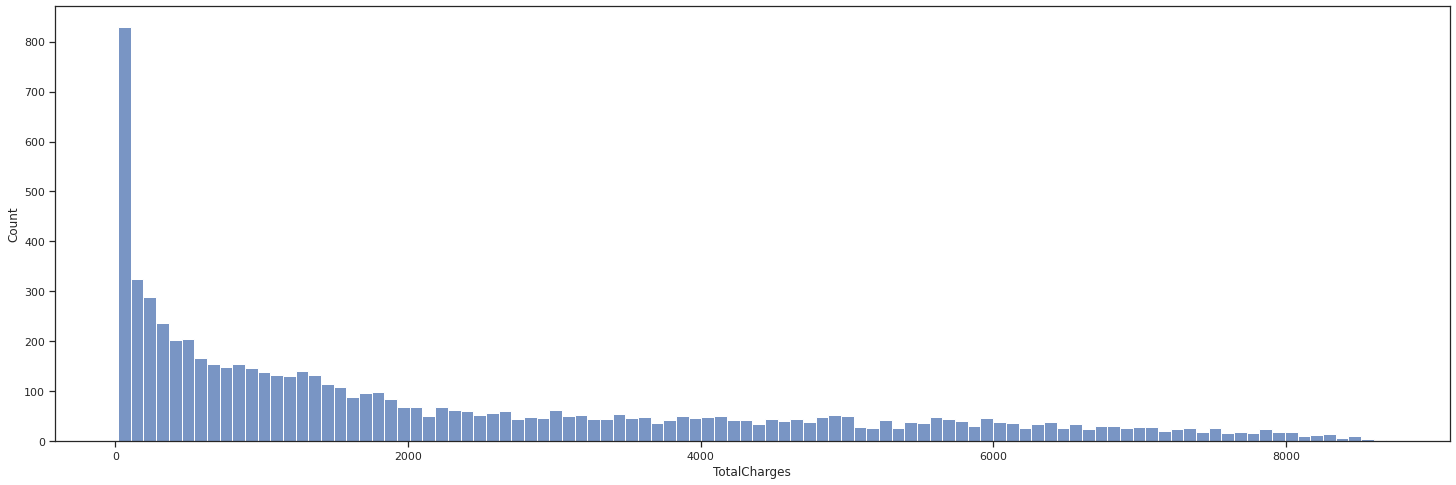

In [18]:
plt.figure(figsize=(25,8))
sns.histplot(contracts['TotalCharges'], bins=100);

Мы видим некий пик в самом начале, кастомеров, чей общий чек не очень высок, но это не нули, возможно это новые пользоыватели или люди которые быстро сменили поставщика услуг.

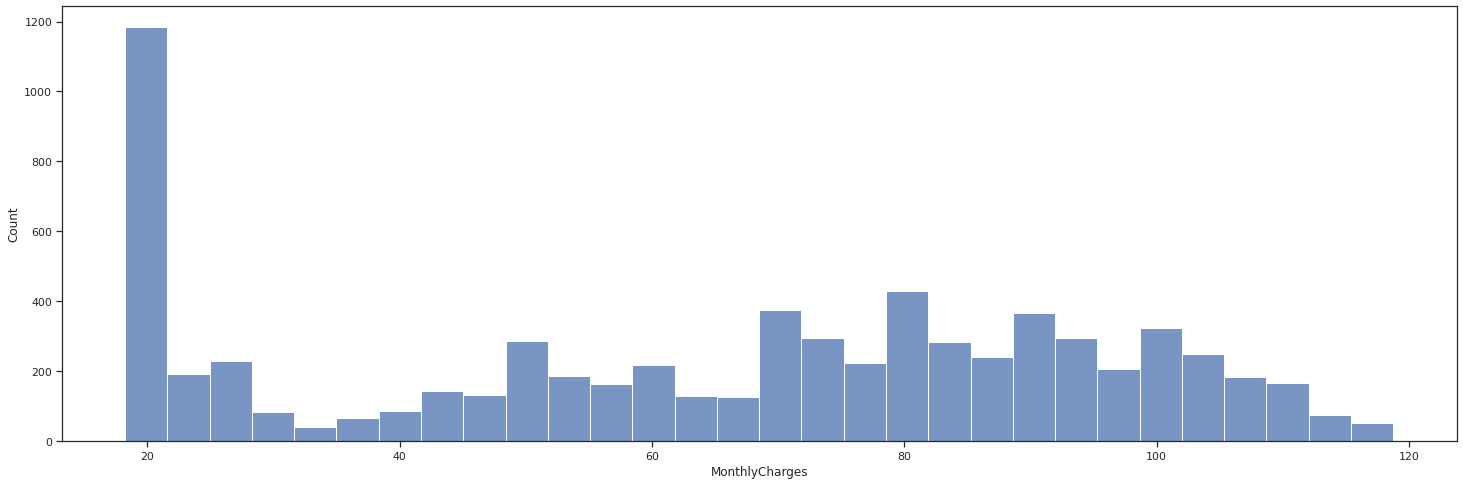

In [19]:
plt.figure(figsize=(25,8))
sns.histplot(contracts['MonthlyCharges'], bins=30);

Здесь мы не видим никаких выбросов, все в пределах нормы ведь тарифы бывают самые разные, но большая доля предпочитает некий минимум.

**Вывод**: мы имеем хорошие данные без лишних выбросов.

## Анализ персональных данных

Посмотрим на персональные данные

In [20]:
df_info(personals)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


,customerID,gender,SeniorCitizen,Partner,Dependents
2519,4927-WWOOZ,Male,0,Yes,No
6699,3662-FXJFO,Female,0,No,No
6153,6685-XSHHU,Male,0,Yes,Yes
6989,1389-WNUIB,Female,0,Yes,Yes
1429,4652-ODEVH,Male,0,Yes,Yes
2108,0842-IWYCP,Female,0,No,No
2166,2931-VUVJN,Female,1,Yes,No
6993,6583-QGCSI,Female,1,Yes,No
6858,2685-SREOM,Female,0,Yes,Yes
2073,3061-BCKYI,Male,0,No,No


Количество полных дубликатов в датафрэйме: 0


В датафрэйме с информацией о персональных данных у нас 7043 записи, без пропусков и без полных дубликатов. В нём так же переведём поля gender, Partner и Dependents в поля с 0 и 1, предварительно проверив значения в этих полях.

In [21]:
personals['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

In [22]:
mapper = {'Male': 1, 'Female': 0}
personals['gender'] = personals['gender'].replace(mapper)
personals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   int64 
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(2), object(3)
memory usage: 275.2+ KB


In [23]:
personals = cast_yes_no_to_one_zero(personals, ['Partner', 'Dependents'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   int64 
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   int64 
 4   Dependents     7043 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 275.2+ KB


In [24]:
personals.sample(10)

,customerID,gender,SeniorCitizen,Partner,Dependents
3281,6322-PJJDJ,1,0,1,0
4886,2673-ZALNP,0,0,0,0
6397,7994-XIRTR,1,1,0,0
3191,7636-OWBPG,1,1,0,0
3212,0585-EGDDA,1,0,1,0
4779,0480-BIXDE,0,0,1,0
5051,0899-WZRSD,1,0,0,0
76,6416-JNVRK,0,0,0,0
2150,5628-FCGYG,1,0,0,0
6307,3043-SUDUA,0,0,0,0


Построим scatter_matrix для датафрэйма с персональными данными.

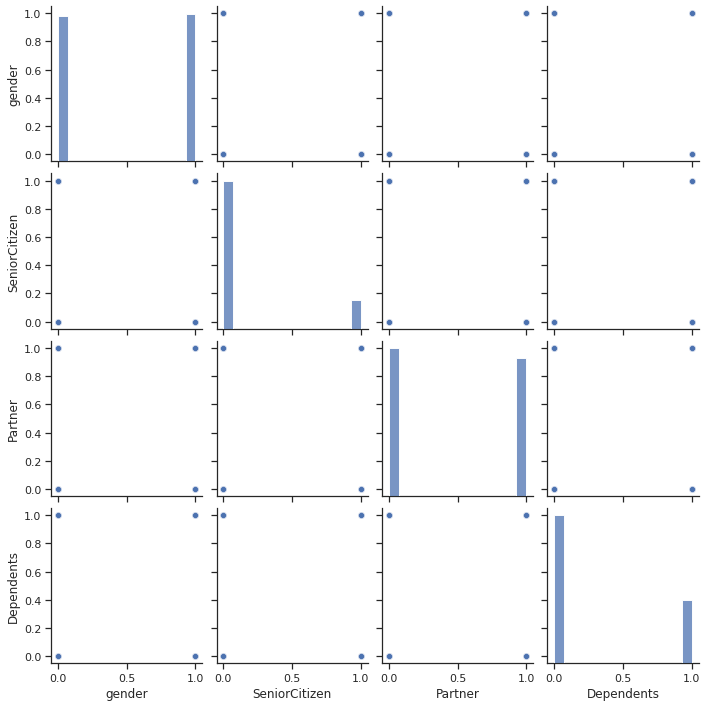

In [25]:
sns.pairplot(personals);

Здесь мы можем только увидеть соотнешние одних к другим. Женщин к мужчинам, и пр.

**Вывод**: здесь мы получили готовый набор признаков для нашей модели.

## Анализ данных о подключенном интернете

In [26]:
df_info(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,3442-ZHHCC,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
252,1557-EMYVT,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
473,5192-EBGOV,Fiber optic,No,No,No,No,Yes,No
1603,8100-HZZLJ,DSL,Yes,Yes,No,No,No,Yes
4779,3317-VLGQT,Fiber optic,No,No,No,No,No,Yes
878,6921-OZMFH,DSL,No,No,No,Yes,No,No
4791,2322-VCZHZ,Fiber optic,Yes,Yes,No,No,No,Yes
619,9505-SQFSW,DSL,No,Yes,No,No,No,Yes
5198,0818-OCPZO,Fiber optic,No,Yes,No,No,No,No
4012,4119-ZYPZY,Fiber optic,No,Yes,No,Yes,Yes,Yes
209,3606-TWKGI,Fiber optic,No,Yes,Yes,No,Yes,Yes


Количество полных дубликатов в датафрэйме: 0


В датафрэйме с информацией о подключенном интернете у нас 5517 записи, без пропусков и без полных дубликатов. В нём так же переведём поля со значениеями Yes/No в 1 и 0.

In [27]:
internet = cast_yes_no_to_one_zero(internet, ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   int64 
 3   OnlineBackup      5517 non-null   int64 
 4   DeviceProtection  5517 non-null   int64 
 5   TechSupport       5517 non-null   int64 
 6   StreamingTV       5517 non-null   int64 
 7   StreamingMovies   5517 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 344.9+ KB


In [28]:
internet.sample(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3668,5956-YHHRX,Fiber optic,0,1,1,0,1,1
4579,9584-EXCDZ,Fiber optic,0,0,0,0,0,0
3942,3255-GRXMG,DSL,0,0,0,0,0,0
1337,1696-MZVAU,DSL,0,0,0,0,0,0
907,9553-DLCLU,DSL,1,1,1,1,1,1
1507,4720-VSTSI,Fiber optic,0,1,1,0,0,0
4623,1840-BIUOG,DSL,0,1,0,1,1,0
395,8372-JUXUI,Fiber optic,0,0,0,0,0,0
2242,4146-SVFUD,DSL,0,0,0,0,0,0
2350,9513-DXHDA,DSL,1,0,1,1,1,1


Здесь на графиках мы тоже можем увидеть только распределение между признаками в столбцах.

**Вывод**: здесь мы тоже получили готовый набор признаков для нашей модели.

## Анализ данных о подключенном телефоне

In [29]:
df_info(phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,8963-JLGJT,No
freq,1,3390


,customerID,MultipleLines
478,1297-VQDRP,Yes
5969,6169-PGNCD,No
3631,2987-BJXIK,Yes
5152,4797-AXPXK,No
803,7549-MYGPK,Yes
1097,0013-MHZWF,No
1974,5159-YFPKQ,No
4337,7762-ONLJY,No
482,5844-QVTAT,No
3811,4291-YZODP,No


Количество полных дубликатов в датафрэйме: 0


В датафрэйме с информацией о подключенном телефоне у нас 6361 запись, без пропусков и без полных дубликатов. В нём переведём поле MultipleLines Yes/No в 1 и 0.

In [30]:
phone = cast_yes_no_to_one_zero(phone, ['MultipleLines'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 99.5+ KB


In [31]:
phone.sample(10)

,customerID,MultipleLines
3725,5214-NLTIT,1
1522,5047-LHVLY,0
1604,5848-FHRFC,0
604,3859-CVCET,0
3779,9741-YLNTD,1
3021,1640-PLFMP,0
2740,8896-BQTTI,1
145,0867-MKZVY,1
2620,1400-WIVLL,1
2786,1666-JXLKU,1


**Вывод**: и здесь мы тоже получили готовый набор признаков для нашей модели.

## Объединение датафрэймов

Объединим наши датафрэймы в общую таблицу с признаками.

In [32]:
features = contracts.set_index('customerID').join(personals.set_index('customerID'))
features = features.join(internet.set_index('customerID'))
features = features.join(phone.set_index('customerID'))
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           1869 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   int64         
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
 7   BeginDate_year    7043 non-null   int64         
 8   BeginDate_month   7043 non-null   int64         
 9   EndDate_year      1869 non-null   float64       
 10  EndDate_month     1869 non-null   float64       
 11  gender            7043 non-null   int64         
 12  SeniorCitizen     7043 non-null   int64         
 13  Partner           7043 non-null   int64         
 14  Dependents    

In [33]:
features.sample(10)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,BeginDate_year,BeginDate_month,EndDate_year,EndDate_month,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,,,,,
1952-DVVSW,2019-04-01,NaT,One year,0,Mailed check,20.10,184.40,2019,4,NaN,NaN,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
8329-IBCTI,2019-12-01,2020-01-01,Month-to-month,0,Mailed check,19.65,19.65,2019,12,2020.0,1.0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1932-UEDCX,2017-05-01,NaT,Month-to-month,1,Bank transfer (automatic),100.60,3270.25,2017,5,NaN,NaN,1,1,1,0,Fiber optic,0.0,1.0,0.0,0.0,1.0,1.0,1.0
6941-PMGEP,2019-06-01,2019-11-01,Month-to-month,1,Electronic check,80.00,412.50,2019,6,2019.0,11.0,0,0,0,0,Fiber optic,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8434-PNQZX,2016-08-01,NaT,Two year,1,Credit card (automatic),78.45,3373.40,2016,8,NaN,NaN,0,0,0,0,DSL,0.0,0.0,1.0,1.0,1.0,1.0,1.0
9514-JDSKI,2019-11-01,2019-12-01,Month-to-month,0,Electronic check,40.20,40.20,2019,11,2019.0,12.0,1,1,1,0,DSL,0.0,1.0,0.0,0.0,1.0,0.0,NaN
6357-JJPQT,2019-11-01,NaT,Month-to-month,1,Electronic check,80.50,232.35,2019,11,NaN,NaN,0,0,0,0,Fiber optic,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6080-TCMYC,2016-10-01,NaT,Month-to-month,1,Electronic check,81.20,3292.30,2016,10,NaN,NaN,1,0,1,1,Fiber optic,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2041-JIJCI,2019-09-01,NaT,Month-to-month,1,Electronic check,64.00,370.25,2019,9,NaN,NaN,0,0,0,0,DSL,0.0,1.0,0.0,0.0,0.0,1.0,1.0


Мы получили датафрэйм с 7043 записями, со всеми нужными нам признаками.

## План решения задачи

1. Подготовить признаки для модели, добавить целовой признак и избавиться от ненужных.
2. Разделить наш датасет на тренировочную, тестовую и валидационую выборки.
3. Попробовать несколько разных моделей классификации и выбрать подходящую, которая будет выдавать лучшие результаты по выбранной нами метрике.
4. Проверить наши модели на адекватность
5. Сделать выводы из полученных результатов.

## Создание и обучение модели

Для начала подготовим наши признаки для обучения модели: 
- выделим целевой на основе поля EndDate, если оно есть значит клиент закрыл контракт
- убёрем customerId, так как этот признак ни на что не влияет
- добавим признак время жизни контракта, сделаем его длительность в секундах
- уберем все даты, чтобы не было утечки целевого признака
- заменим NaN на 0 в столбцах где у нас бинарные признаки
- сделаем encoding категориальных данных

In [34]:
features.reset_index(inplace=True)
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   BeginDate_year    7043 non-null   int64         
 9   BeginDate_month   7043 non-null   int64         
 10  EndDate_year      1869 non-null   float64       
 11  EndDate_month     1869 non-null   float64       
 12  gender            7043 non-null   int64         
 13  SeniorCitizen     7043 non-null   int64         
 14  Partner           7043 n

Вычислим время жизни контрактов в днях

In [35]:
importDataDate = pd.Timestamp(2020,2,1)

def fill_contract_lifetime_days(row):
    endDate = row['EndDate']
    contract_lifetime_days = 0
    if pd.isnull(endDate):
        contract_lifetime_days = importDataDate - row['BeginDate']
    else:
        contract_lifetime_days = endDate - row['BeginDate']

    row['contractLifetime_days'] = contract_lifetime_days / np.timedelta64(1,'D')
    return row

features = features.apply(fill_contract_lifetime_days, axis=1)
features.info()
features.sample(5, random_state=12345)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   customerID             7043 non-null   object        
 1   BeginDate              7043 non-null   datetime64[ns]
 2   EndDate                1869 non-null   datetime64[ns]
 3   Type                   7043 non-null   object        
 4   PaperlessBilling       7043 non-null   int64         
 5   PaymentMethod          7043 non-null   object        
 6   MonthlyCharges         7043 non-null   float64       
 7   TotalCharges           7032 non-null   float64       
 8   BeginDate_year         7043 non-null   int64         
 9   BeginDate_month        7043 non-null   int64         
 10  EndDate_year           1869 non-null   float64       
 11  EndDate_month          1869 non-null   float64       
 12  gender                 7043 non-null   int64         
 13  Sen

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,BeginDate_year,BeginDate_month,EndDate_year,EndDate_month,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,contractLifetime_days
1128,0098-BOWSO,2017-11-01,NaT,Month-to-month,1,Electronic check,19.40,529.80,2017,11,NaN,NaN,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,822.0
2875,9992-RRAMN,2018-02-01,2019-12-01,Month-to-month,1,Electronic check,85.10,1873.70,2018,2,2019.0,12.0,1,0,1,0,Fiber optic,0.0,0.0,0.0,0.0,0.0,1.0,1.0,668.0
1783,8380-PEFPE,2019-09-01,2019-10-01,Month-to-month,1,Electronic check,71.65,71.65,2019,9,2019.0,10.0,1,0,0,1,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0
3804,9773-PEQBZ,2019-04-01,NaT,Month-to-month,0,Electronic check,79.85,797.25,2019,4,NaN,NaN,1,0,0,0,Fiber optic,0.0,1.0,0.0,0.0,0.0,0.0,1.0,306.0
6087,8319-QBEHW,2017-12-01,NaT,One year,1,Bank transfer (automatic),39.95,1023.75,2017,12,NaN,NaN,1,0,0,1,DSL,0.0,1.0,0.0,0.0,1.0,0.0,NaN,792.0


Так как у нас есть количество дней, сколько длился контракт, мы можем заполнить пропуски в поле TotalCharges, так как таких данных немного, мы можем допустить погрешность в оплате счёта на 1 месяц.

In [36]:
def fill_total_charge(row):
    if np.isnan(row['TotalCharges']):
        row['TotalCharges'] = row['contractLifetime_days'] / 30 * row['MonthlyCharges']
    return row

features = features.apply(fill_total_charge, axis=1)
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   customerID             7043 non-null   object        
 1   BeginDate              7043 non-null   datetime64[ns]
 2   EndDate                1869 non-null   datetime64[ns]
 3   Type                   7043 non-null   object        
 4   PaperlessBilling       7043 non-null   int64         
 5   PaymentMethod          7043 non-null   object        
 6   MonthlyCharges         7043 non-null   float64       
 7   TotalCharges           7043 non-null   float64       
 8   BeginDate_year         7043 non-null   int64         
 9   BeginDate_month        7043 non-null   int64         
 10  EndDate_year           1869 non-null   float64       
 11  EndDate_month          1869 non-null   float64       
 12  gender                 7043 non-null   int64         
 13  Sen

Выделим целевой признак

In [37]:
target = features.apply(lambda row: 0 if pd.isnull(row['EndDate']) else 1, axis=1)
target.value_counts()

0    5174
1    1869
dtype: int64

Удалим не нужные поля с датой и customerID.

In [38]:
features.drop(columns=['customerID', 'BeginDate', 'EndDate','BeginDate_year','BeginDate_month','EndDate_year','EndDate_month'], inplace=True)
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Type                   7043 non-null   object 
 1   PaperlessBilling       7043 non-null   int64  
 2   PaymentMethod          7043 non-null   object 
 3   MonthlyCharges         7043 non-null   float64
 4   TotalCharges           7043 non-null   float64
 5   gender                 7043 non-null   int64  
 6   SeniorCitizen          7043 non-null   int64  
 7   Partner                7043 non-null   int64  
 8   Dependents             7043 non-null   int64  
 9   InternetService        5517 non-null   object 
 10  OnlineSecurity         5517 non-null   float64
 11  OnlineBackup           5517 non-null   float64
 12  DeviceProtection       5517 non-null   float64
 13  TechSupport            5517 non-null   float64
 14  StreamingTV            5517 non-null   float64
 15  Stre

Заменим NaN на строку None, чтобы избавиться от пропусков.

In [39]:
features['InternetService'] = features['InternetService'].fillna('None')
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Type                   7043 non-null   object 
 1   PaperlessBilling       7043 non-null   int64  
 2   PaymentMethod          7043 non-null   object 
 3   MonthlyCharges         7043 non-null   float64
 4   TotalCharges           7043 non-null   float64
 5   gender                 7043 non-null   int64  
 6   SeniorCitizen          7043 non-null   int64  
 7   Partner                7043 non-null   int64  
 8   Dependents             7043 non-null   int64  
 9   InternetService        7043 non-null   object 
 10  OnlineSecurity         5517 non-null   float64
 11  OnlineBackup           5517 non-null   float64
 12  DeviceProtection       5517 non-null   float64
 13  TechSupport            5517 non-null   float64
 14  StreamingTV            5517 non-null   float64
 15  Stre

Заменим NaN на 0 в бинарных полях.

In [40]:
values = {
    'PaperlessBilling': 0, 
    'OnlineSecurity': 0, 
    'OnlineBackup': 0, 
    'DeviceProtection': 0,
    'TechSupport': 0,
    'StreamingTV': 0,
    'StreamingMovies': 0,
    'MultipleLines': 0
}
features.fillna(value=values, inplace=True)
features.info()
features.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Type                   7043 non-null   object 
 1   PaperlessBilling       7043 non-null   int64  
 2   PaymentMethod          7043 non-null   object 
 3   MonthlyCharges         7043 non-null   float64
 4   TotalCharges           7043 non-null   float64
 5   gender                 7043 non-null   int64  
 6   SeniorCitizen          7043 non-null   int64  
 7   Partner                7043 non-null   int64  
 8   Dependents             7043 non-null   int64  
 9   InternetService        7043 non-null   object 
 10  OnlineSecurity         7043 non-null   float64
 11  OnlineBackup           7043 non-null   float64
 12  DeviceProtection       7043 non-null   float64
 13  TechSupport            7043 non-null   float64
 14  StreamingTV            7043 non-null   float64
 15  Stre

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,contractLifetime_days
5221,One year,1,Electronic check,107.45,7047.5,0,1,1,1,Fiber optic,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1979.0
432,Month-to-month,0,Electronic check,53.45,119.5,1,0,0,0,DSL,1.0,0.0,1.0,0.0,0.0,0.0,0.0,62.0
1791,One year,1,Mailed check,61.50,2722.2,0,0,1,0,DSL,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1340.0
1542,Two year,1,Electronic check,21.10,937.1,0,0,0,0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1401.0
5771,Month-to-month,0,Mailed check,20.40,266.6,0,0,0,0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,365.0


In [41]:
convert_dict = {
    'OnlineSecurity': int, 
    'OnlineBackup': int, 
    'DeviceProtection': int,
    'TechSupport': int,
    'StreamingTV': int,
    'StreamingMovies': int,
    'MultipleLines': int,
    'contractLifetime_days': int
}
  
features = features.astype(convert_dict) 
features.dtypes

Type                      object
PaperlessBilling           int64
PaymentMethod             object
MonthlyCharges           float64
TotalCharges             float64
gender                     int64
SeniorCitizen              int64
Partner                    int64
Dependents                 int64
InternetService           object
OnlineSecurity             int64
OnlineBackup               int64
DeviceProtection           int64
TechSupport                int64
StreamingTV                int64
StreamingMovies            int64
MultipleLines              int64
contractLifetime_days      int64
dtype: object

In [42]:
features.sample(5)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,contractLifetime_days
2285,Month-to-month,0,Electronic check,93.90,5029.20,1,0,1,0,Fiber optic,1,0,1,0,0,1,1,1614
4085,One year,1,Credit card (automatic),40.35,1187.05,0,0,0,0,DSL,0,0,0,1,0,1,0,914
4594,Month-to-month,1,Electronic check,102.80,2110.15,0,0,1,1,Fiber optic,0,1,1,1,1,1,0,640
2909,One year,0,Electronic check,55.45,2444.25,0,0,0,0,DSL,0,1,0,1,0,0,0,1310
1350,Two year,0,Mailed check,65.65,4322.85,0,0,1,0,DSL,1,1,1,0,0,0,1,2041


Мы получили признаки и целевой признак, можно приступать к обучению моделей. В качестве моделей для обучения, возьмем случайный лес и CatBoostClassifier.

Сделаем OrdinalEncoding для категориальных полей, чтобы сделать данные подходящими для обучения случайного леса.

In [43]:
encoded_features = features.copy()

In [44]:
typeordinalencoder = OrdinalEncoder()
type_ord = typeordinalencoder.fit_transform(encoded_features[['Type']])
type_ord = pd.DataFrame(type_ord, columns=['Type'])
#type_ord.value_counts()

In [45]:
encoded_features.loc[:, 'Type'] = type_ord.loc[:, 'Type']
encoded_features.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,contractLifetime_days
0,0.0,1,Electronic check,29.85,29.85,0,0,1,0,DSL,0,1,0,0,0,0,0,31
1,1.0,0,Mailed check,56.95,1889.50,1,0,0,0,DSL,1,0,1,0,0,0,0,1036
2,0.0,1,Mailed check,53.85,108.15,1,0,0,0,DSL,1,1,0,0,0,0,0,61
3,1.0,0,Bank transfer (automatic),42.30,1840.75,1,0,0,0,DSL,1,0,1,1,0,0,0,1371
4,0.0,1,Electronic check,70.70,151.65,0,0,0,0,Fiber optic,0,0,0,0,0,0,0,61


In [46]:
payment_method_ordinalencoder = OrdinalEncoder()
payment_method_ord = payment_method_ordinalencoder.fit_transform(encoded_features[['PaymentMethod']])
payment_method_ord = pd.DataFrame(payment_method_ord, columns=['PaymentMethod'])
payment_method_ord.value_counts()

PaymentMethod
2.0              2365
3.0              1612
0.0              1544
1.0              1522
dtype: int64

In [47]:
encoded_features.loc[:, 'PaymentMethod'] = payment_method_ord.loc[:, 'PaymentMethod']
encoded_features.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,contractLifetime_days
0,0.0,1,2.0,29.85,29.85,0,0,1,0,DSL,0,1,0,0,0,0,0,31
1,1.0,0,3.0,56.95,1889.50,1,0,0,0,DSL,1,0,1,0,0,0,0,1036
2,0.0,1,3.0,53.85,108.15,1,0,0,0,DSL,1,1,0,0,0,0,0,61
3,1.0,0,0.0,42.30,1840.75,1,0,0,0,DSL,1,0,1,1,0,0,0,1371
4,0.0,1,2.0,70.70,151.65,0,0,0,0,Fiber optic,0,0,0,0,0,0,0,61


In [48]:
internet_service_ordinalencoder = OrdinalEncoder()
internet_service_ord = internet_service_ordinalencoder.fit_transform(encoded_features[['InternetService']])
internet_service_ord = pd.DataFrame(internet_service_ord, columns=['InternetService'])
internet_service_ord.value_counts()

InternetService
1.0                3096
0.0                2421
2.0                1526
dtype: int64

In [49]:
encoded_features.loc[:, 'InternetService'] = internet_service_ord.loc[:, 'InternetService']
encoded_features.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,contractLifetime_days
0,0.0,1,2.0,29.85,29.85,0,0,1,0,0.0,0,1,0,0,0,0,0,31
1,1.0,0,3.0,56.95,1889.50,1,0,0,0,0.0,1,0,1,0,0,0,0,1036
2,0.0,1,3.0,53.85,108.15,1,0,0,0,0.0,1,1,0,0,0,0,0,61
3,1.0,0,0.0,42.30,1840.75,1,0,0,0,0.0,1,0,1,1,0,0,0,1371
4,0.0,1,2.0,70.70,151.65,0,0,0,0,1.0,0,0,0,0,0,0,0,61


После объединения и приведения признаков к единному формату, проверим не появилось ли у нас мультиколинеарности между признаками.

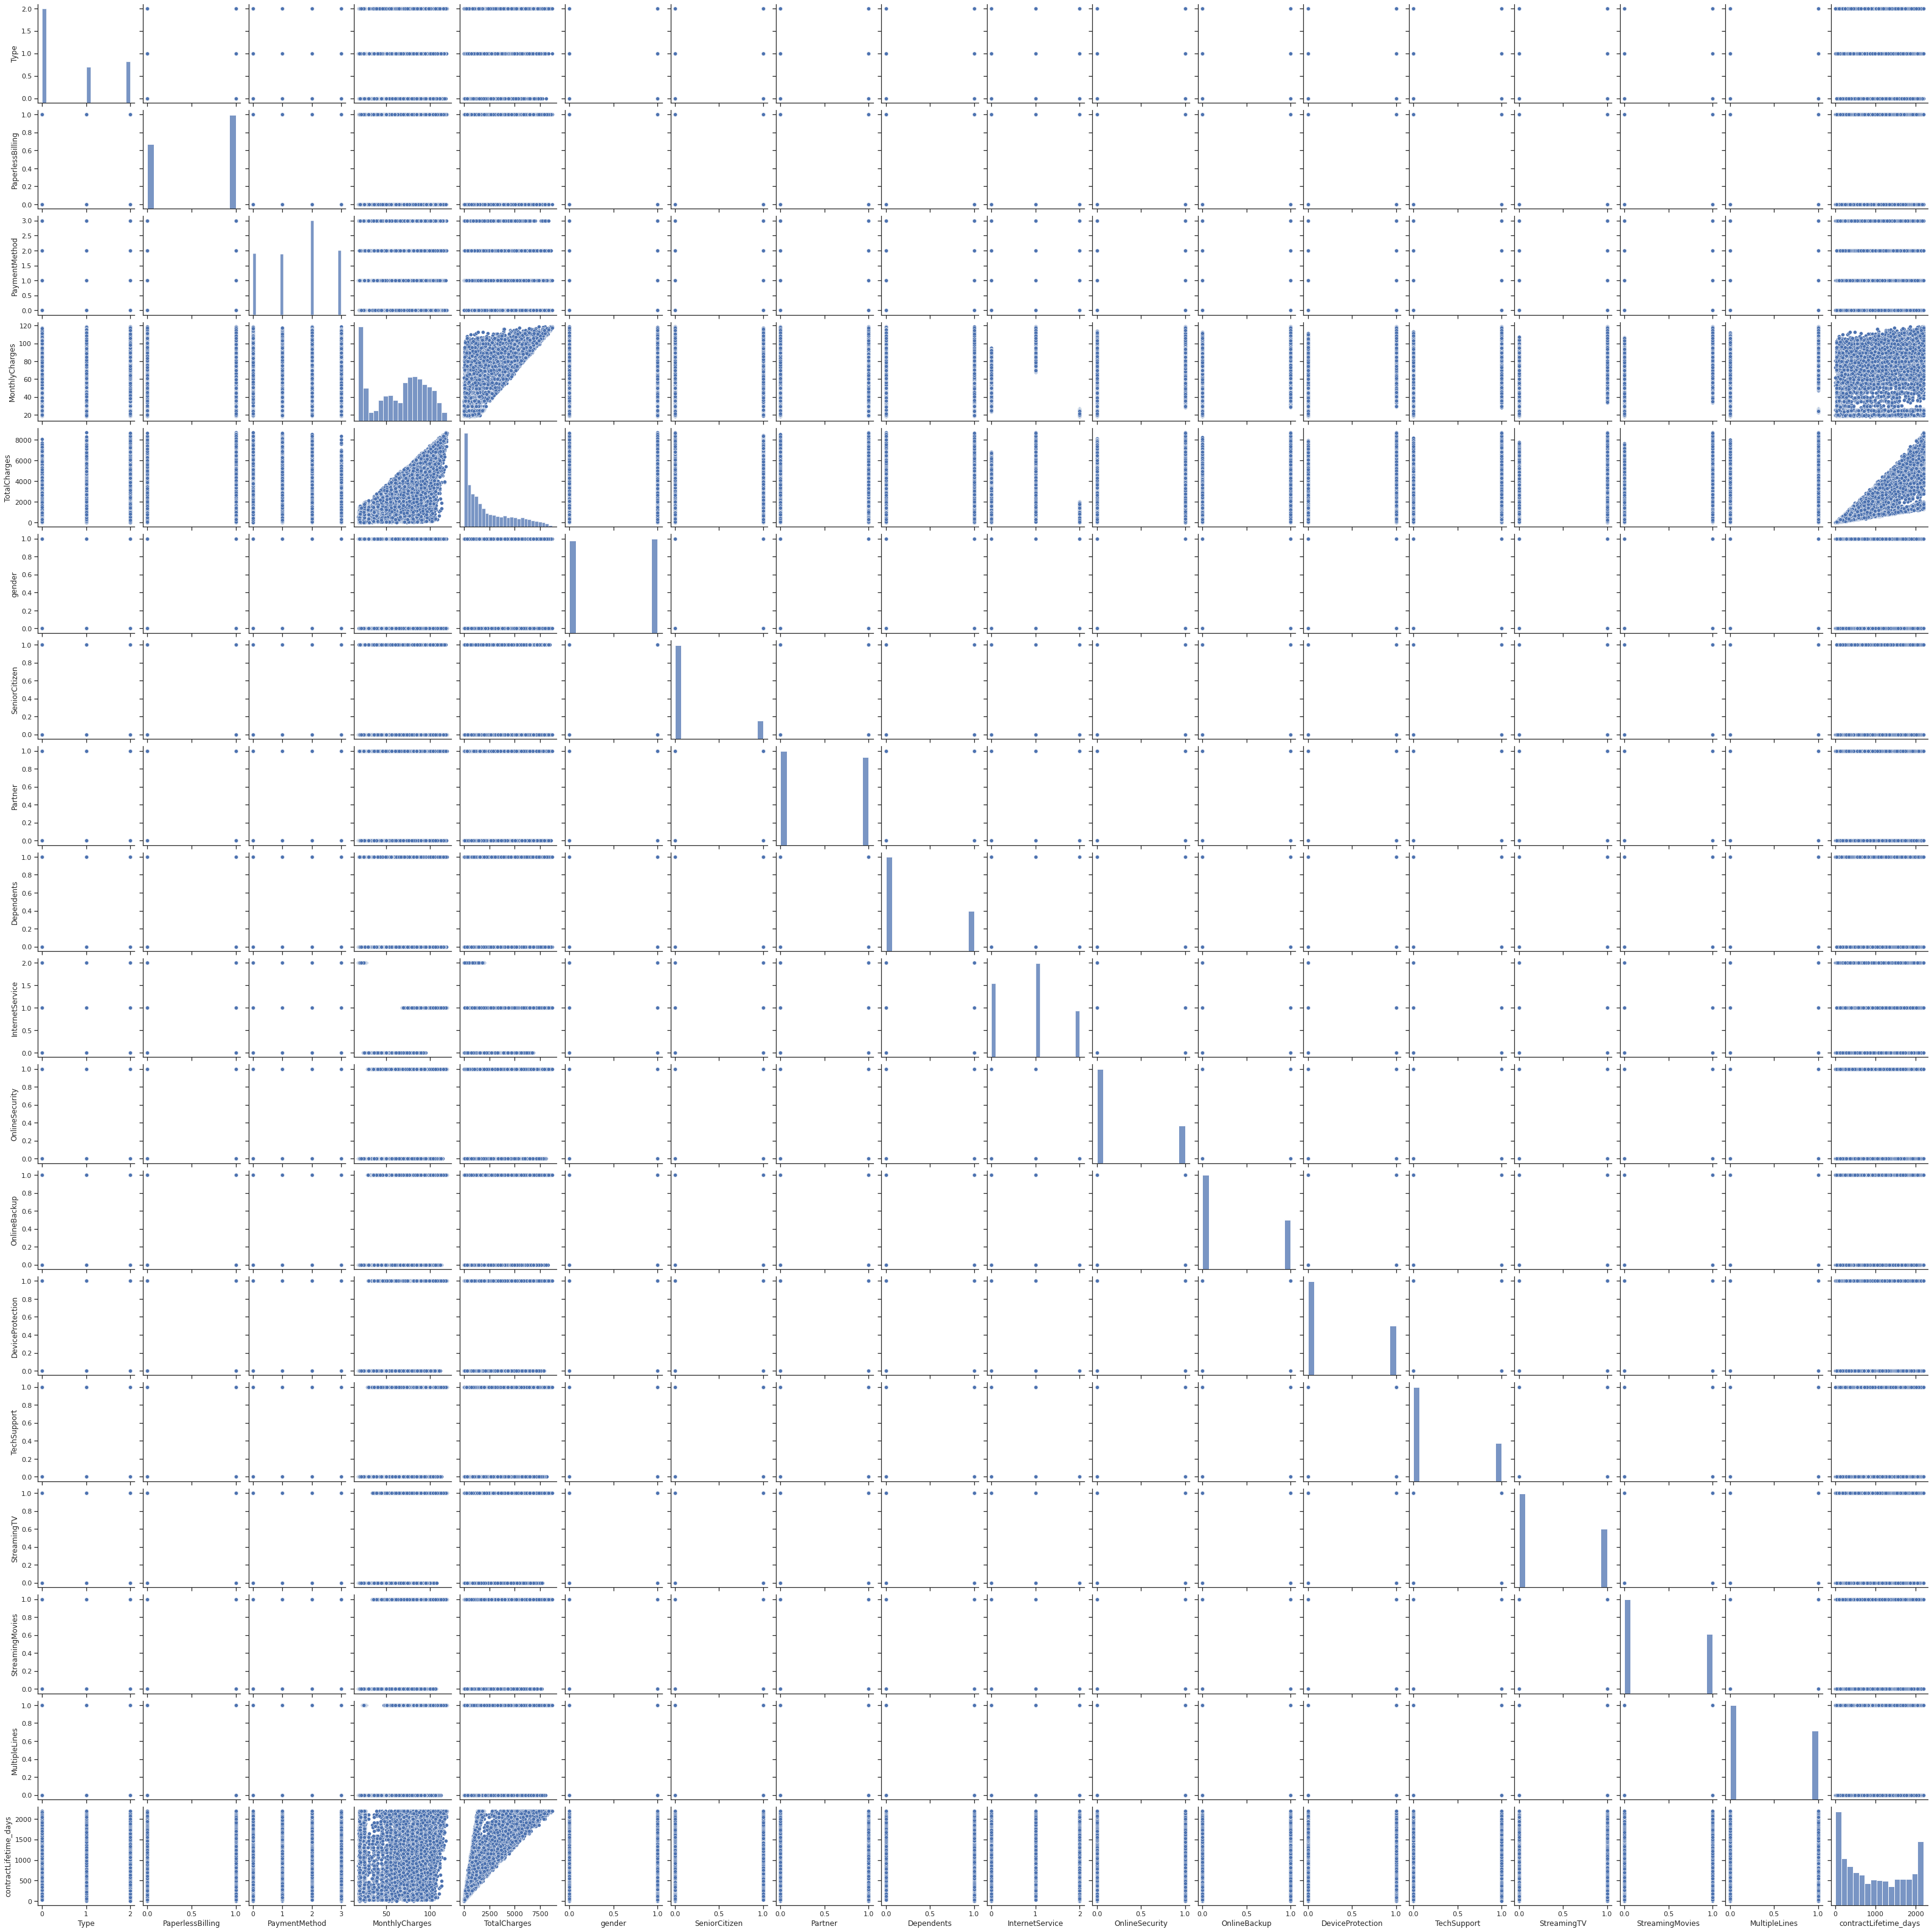

In [50]:
sns.pairplot(encoded_features);

Посмотрев на график мы можем заметить, что мультиколлинеарности здесь нет, единственная корреляция которую мы видим - это корреляция между MonthlyCharges, TotalCharges и временем жизни контракта, чем выше месячная стоимость, тем выше итоговый чек, и чем дольше ты пользуешься услугами, тем твой общий чек больше.

In [51]:
encoded_features.corr()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,contractLifetime_days
Type,1.000000,-0.176733,-0.227543,-0.074195,0.446855,0.000126,-0.142554,0.294806,0.243187,0.099721,0.245530,0.155085,0.219310,0.293691,0.103944,0.107520,0.107114,0.671657
PaperlessBilling,-0.176733,1.000000,-0.062904,0.352150,0.158574,-0.011754,0.156530,-0.014877,-0.111377,-0.138625,-0.003636,0.126735,0.103797,0.037880,0.223841,0.211716,0.163530,0.006059
PaymentMethod,-0.227543,-0.062904,1.000000,-0.193407,-0.330918,0.017352,-0.038551,-0.154798,-0.040292,0.086140,-0.150100,-0.170898,-0.181085,-0.157272,-0.148865,-0.154984,-0.171026,-0.370402
MonthlyCharges,-0.074195,0.352150,-0.193407,1.000000,0.651174,-0.014569,0.220173,0.096848,-0.113890,-0.323260,0.296594,0.441780,0.482692,0.338304,0.629603,0.627429,0.490434,0.247754
TotalCharges,0.446855,0.158574,-0.330918,0.651174,1.000000,-0.000080,0.103006,0.317504,0.062078,-0.175755,0.411651,0.509226,0.521983,0.431883,0.514973,0.520122,0.468504,0.826109
gender,0.000126,-0.011754,0.017352,-0.014569,-0.000080,1.000000,-0.001874,-0.001808,0.010517,-0.000863,-0.017021,-0.013773,-0.002105,-0.009212,-0.008393,-0.010487,-0.008414,0.005111
SeniorCitizen,-0.142554,0.156530,-0.038551,0.220173,0.103006,-0.001874,1.000000,0.016479,-0.211185,-0.032310,-0.038653,0.066572,0.059428,-0.060625,0.105378,0.120176,0.142948,0.016514
Partner,0.294806,-0.014877,-0.154798,0.096848,0.317504,-0.001808,0.016479,1.000000,0.452676,0.000891,0.143106,0.141498,0.153786,0.119999,0.124666,0.117412,0.142057,0.379709
Dependents,0.243187,-0.111377,-0.040292,-0.113890,0.062078,0.010517,-0.211185,0.452676,1.000000,0.044590,0.080972,0.023671,0.013963,0.063268,-0.016558,-0.039741,-0.024526,0.159766
InternetService,0.099721,-0.138625,0.086140,-0.323260,-0.175755,-0.000863,-0.032310,0.000891,0.044590,1.000000,-0.393013,-0.314737,-0.306805,-0.389382,-0.242532,-0.250343,0.011124,-0.030334


Данные заэнкодены, выделим тренировачную, валидационную и тестовую выборки в соотношении 80:10:10.

In [52]:
X_train, X_valid_test, y_train, y_valid_test = train_test_split(encoded_features, target, test_size=0.2, stratify=target, random_state=123)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, test_size=0.5, stratify=y_valid_test, random_state=123)

In [53]:
def print_auc_roc(model, X, y):
    probabilities_valid = model.predict_proba(X)
    probabilities_one_valid = probabilities_valid[:, 1]

    auc_roc = roc_auc_score(y, probabilities_one_valid)

    print('AUC-ROC: {}'.format(auc_roc))

В качестве первой модели возьмём случайный лес.

In [54]:
forest_param_grid = {
    'max_depth': [deep for deep in range(4, 18, 2)],
    'n_estimators': [150, 200, 250]
}

forest_gs = GridSearchCV(RandomForestClassifier(random_state=123, class_weight='balanced'), param_grid=forest_param_grid, cv = 5, n_jobs=-2)


In [55]:
%%time
forest_gs.fit(X_train, y_train)

print(forest_gs.best_params_)

{'max_depth': 16, 'n_estimators': 250}
CPU times: user 1min 19s, sys: 163 ms, total: 1min 20s
Wall time: 1min 20s


Feature: 0, Score: 0.13504
Feature: 1, Score: 0.02455
Feature: 2, Score: 0.04795
Feature: 3, Score: 0.17099
Feature: 4, Score: 0.16229
Feature: 5, Score: 0.02241
Feature: 6, Score: 0.01660
Feature: 7, Score: 0.01905
Feature: 8, Score: 0.01984
Feature: 9, Score: 0.05485
Feature: 10, Score: 0.02430
Feature: 11, Score: 0.01765
Feature: 12, Score: 0.01626
Feature: 13, Score: 0.02393
Feature: 14, Score: 0.01541
Feature: 15, Score: 0.01702
Feature: 16, Score: 0.01607
Feature: 17, Score: 0.19579


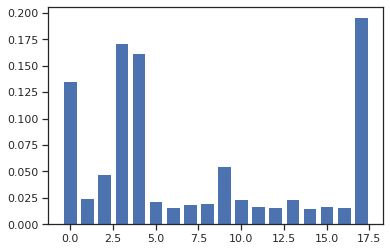

In [56]:
importance = forest_gs.best_estimator_.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Самыми главными факторами для предсказания модель случайного леса посчитала время жизни:

1. Время жизни контракта
2. Сумму помесячной оплаты
3. Общий чек за всё время
4. Тип контракта

In [57]:
%%time
forest_predict = forest_gs.predict(X_valid)

CPU times: user 57.9 ms, sys: 0 ns, total: 57.9 ms
Wall time: 57.5 ms


In [58]:
print(classification_report(y_valid, forest_predict))
print_auc_roc(forest_gs, X_valid, y_valid)
print()
print('Train accuracy score: {}'.format(forest_gs.score(X_train, y_train)))
print('Valid accuracy score: {}'.format(forest_gs.score(X_valid, y_valid)))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       517
           1       0.70      0.53      0.60       187

    accuracy                           0.82       704
   macro avg       0.77      0.72      0.74       704
weighted avg       0.81      0.82      0.81       704

AUC-ROC: 0.8504742498370899

Train accuracy score: 0.986332978345758
Valid accuracy score: 0.8153409090909091


С помощью classification_report мы можем сразу обратить внимание на все интерисующие нас метрики. Мы можем наблюдать достаточно высокий accuracy на валидационной выборке, но мы видим что у нас есть дисбаланс классов, 0 предсказывается гораздо лучше чем 1, об этом на говрит метрика F1-score. Т.е. факт ухода модель предсказывает хуже.

In [59]:
prediction = forest_gs.predict(X_test)

In [60]:
print(classification_report(y_test, prediction))
print_auc_roc(forest_gs, X_test, y_test)
print()
forest_test_score = forest_gs.score(X_test, y_test)
print('Test accuracy score: {}'.format(forest_test_score))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       518
           1       0.68      0.63      0.65       187

    accuracy                           0.82       705
   macro avg       0.77      0.76      0.76       705
weighted avg       0.82      0.82      0.82       705

AUC-ROC: 0.8525901761195879

Test accuracy score: 0.8212765957446808


In [61]:
X_boosting_train, X_boosting_valid_test, y_boosting_train, y_boosting_valid_test = train_test_split(features, target, test_size=0.2, stratify=target, random_state=123)
X_boosting_valid, X_boosting_test, y_boosting_valid, y_boosting_test = train_test_split(X_boosting_valid_test, y_boosting_valid_test, test_size=0.5, stratify=y_valid_test, random_state=123)

In [62]:
cat_features = [0,2,9]

In [63]:
catboost_parameters = {
    'depth': [deep for deep in range(10, 16, 2)],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [80, 100, 150]
}

catboost_model = CatBoostClassifier(cat_features=cat_features, task_type='GPU', logging_level='Silent')
catboost_grid = GridSearchCV(estimator=catboost_model, param_grid = catboost_parameters, cv = 5, n_jobs=-2)

In [64]:
%%time
catboost_grid.fit(X_boosting_train, y_boosting_train)

CPU times: user 12min 36s, sys: 8min 2s, total: 20min 38s
Wall time: 16min 41s


GridSearchCV(cv=5, error_score=nan,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f97076f6f28>,
             iid='deprecated', n_jobs=-2,
             param_grid={'depth': [10, 12, 14], 'iterations': [80, 100, 150],
                         'learning_rate': [0.01, 0.05, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [65]:
catboost_grid.best_estimator_.get_params()

{'cat_features': [0, 2, 9],
 'depth': 12,
 'iterations': 150,
 'learning_rate': 0.1,
 'logging_level': 'Silent',
 'task_type': 'GPU'}

Feature: 0, Score: 10.26722
Feature: 1, Score: 4.53382
Feature: 2, Score: 11.21141
Feature: 3, Score: 5.00855
Feature: 4, Score: 4.52530
Feature: 5, Score: 7.50934
Feature: 6, Score: 3.06822
Feature: 7, Score: 5.37476
Feature: 8, Score: 2.54474
Feature: 9, Score: 8.31168
Feature: 10, Score: 2.96282
Feature: 11, Score: 3.63959
Feature: 12, Score: 3.37187
Feature: 13, Score: 3.85081
Feature: 14, Score: 2.48225
Feature: 15, Score: 3.39898
Feature: 16, Score: 3.78904
Feature: 17, Score: 14.14960


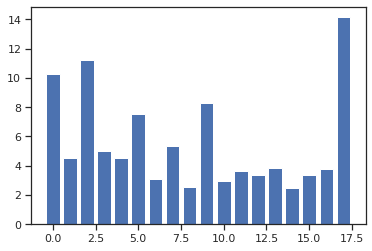

In [66]:
importance = catboost_grid.best_estimator_.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

А вот CatBoost посчитал всё немного иначе, хотя обе модели сошлись на том, что главным фактором является время жизни контракта:
1. Время жизни контракта
2. Тип оплаты
3. Тип контракта
4. Наличие подключения к интернету

In [67]:
%%time
catboost_predictions_valid = catboost_grid.predict(X_boosting_valid)

CPU times: user 13.1 ms, sys: 3.05 ms, total: 16.2 ms
Wall time: 8.81 ms


In [68]:
print(classification_report(y_boosting_valid, catboost_predictions_valid))
print()
print_auc_roc(catboost_grid, X_boosting_valid, y_boosting_valid)
catboost_test_score = catboost_grid.score(X_boosting_valid, y_boosting_valid)
print('Valid accuracy score: {}'.format(catboost_test_score))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       517
           1       0.74      0.53      0.62       187

    accuracy                           0.83       704
   macro avg       0.79      0.73      0.75       704
weighted avg       0.82      0.83      0.82       704


AUC-ROC: 0.8486537924471704
Valid accuracy score: 0.8252840909090909


In [69]:
catboost_predictions_test = catboost_grid.predict(X_boosting_test)

In [70]:
print(classification_report(y_boosting_test, catboost_predictions_test))
print()
print_auc_roc(catboost_grid, X_boosting_test, y_boosting_test)
catboost_test_score = catboost_grid.score(X_boosting_test, y_boosting_test)
print('Test accuracy score: {}'.format(catboost_test_score))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       518
           1       0.70      0.59      0.64       187

    accuracy                           0.82       705
   macro avg       0.78      0.75      0.76       705
weighted avg       0.82      0.82      0.82       705


AUC-ROC: 0.8577364606776371
Test accuracy score: 0.8241134751773049


**Вывод:** мы рассмотрел две модели, модель случайного леса и CatBoostClassifier, хоть они и делают одно и тоже, но работают совершенно по разному и в нашем случае мы добились практически идентичных результатов для двух моделей, хоть CatBoostClassifier и точнее, но совсем немного и не стоит тратить мощность и усилия для её использования. На текущий момент нам достаточно модели случайного леса.

## Проверка модели на вменяемость

In [71]:
dclf = DummyClassifier(strategy = 'most_frequent', random_state = 123) 

In [72]:
dclf.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=123, strategy='most_frequent')

In [73]:
dummy_prediction = dclf.predict(X_test)

In [74]:
print(classification_report(y_test, dummy_prediction))
print()
print_auc_roc(dclf, X_test, y_test)
dummy_test_score = dclf.score(X_test, y_test)
print('Dummy accuracy score: {}'.format(dummy_test_score))
print('Random Forest accuracy score: {}'.format(forest_test_score))

              precision    recall  f1-score   support

           0       0.73      1.00      0.85       518
           1       0.00      0.00      0.00       187

    accuracy                           0.73       705
   macro avg       0.37      0.50      0.42       705
weighted avg       0.54      0.73      0.62       705


AUC-ROC: 0.5
Dummy accuracy score: 0.7347517730496453
Random Forest accuracy score: 0.8212765957446808


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Отчёт

План задачи был выполнен полностью по пунктам, для меня основной сложностью это был поиск взаимосвязей(корреляций) в данном проекте, вся остальная техническая часть была достаточно проста. Ключевым моментом в этом проекте было не допустить утечку целевого признака, надо было внимательно отбирать признаки и выделять новые. Для проекта я попробовал две модели, простую и сложную, а именно случайный лес и CatBoostClassifier, обе модели показали хорошие результаты на валидационных и тестовых выборках, наша целевая метрика ROC-AUC в обоих случаях оказалась > 0.85, а так же accuracy был > 80%, хоть данные были и не сбалансированными. Хоть CatBoostClassifier и показал себя лучше, но совсем немного, поэтому на начальном этапе более оптимальным решением будет случайный лес, он тренируется сильно быстрее даже на CPU и не требует больших мощностей. В дальнейшем при большем объеме данных возможно CatBoostClassifier покажет себя лучше.